In [1]:
import numpy as np
import matplotlib.pyplot as pl
np.random.seed(0)
figdir = "./fig/noise-filtering/"

from functions import *

# Unsupervised noise filtering using Kalman filter

## Define input

In [2]:
niter_all = 2000
nin = 1
iters = np.array(range(niter_all))
ds = np.cos( (2*np.pi/100)*iters ).reshape((nin, -1))

sig_train = 0.01
sig_test = 1
ds_train = ds + np.random.normal(0,1, ds.shape)*sig_train
ds_test = ds + np.random.normal(0,1, ds.shape)*sig_test

## Define and simulate ESN　(pre-training of system model)

In [3]:
nr = 10
Aamp = 0.02
Brho = 0.9
sig = lambda r: r
arcsig = lambda r: r
A, B, g = gen_ESN(nin, nr, Aamp, Brho, sig)
rs_train = np.zeros((nr, niter_all))
for it in range(niter_all-1):
    rs_train[:, it+1] = g( ds_train[:, it], rs_train[:, it] )

lam = 1e-5
# Bh = calc_Bhat(rs_train, arcsig)
Bh = calc_Bhat_reg(rs_train, arcsig, nr, lam)
WR = calc_WR(rs_train, A, B, arcsig)
fh_WR = lambda r : sig( Bh@r )
ws = rs_train[:,1:] - sig( Bh@rs_train[:,:-1] )
Q = ws@ws.T / (niter_all-2)

## simulate ESN (noise filtering)

In [4]:
rs_test = np.zeros((nr, niter_all))
for it in range(niter_all-1):
    rs_test[:, it+1] = g( ds_test[:, it], rs_test[:, it] )
vs_opt = rs_test - rs_train
R_opt = vs_opt@vs_opt.T / (niter_all-2)

# Adaptive Kalman filter
F = Bh
G = np.eye(nr)
H = np.eye(nr)
alpha_R = 0.1
rs_filt_p, rs_filt_o, Ps_p, Ps_o, Rs, Ks = EKF_adapt_R(rs_test,F,G,H,Q,alpha_R)
rs_filt_p_opt, rs_filt_o_opt, Ps_p_opt, Ps_o_opt, Ks = EKF(rs_test,F,G,H,Q,R_opt)

## Show a typical result

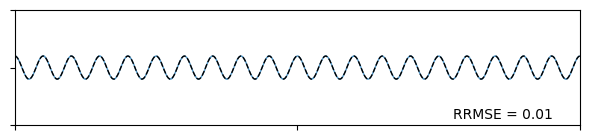

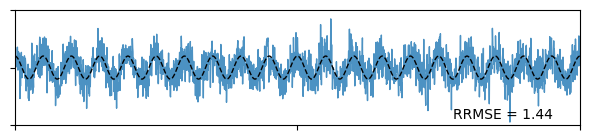

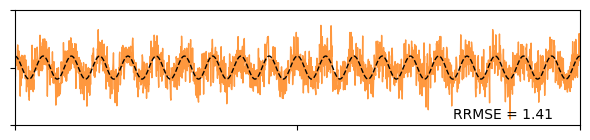

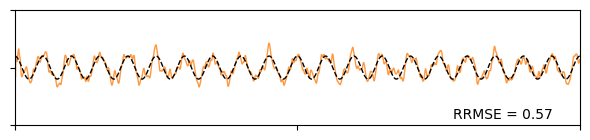

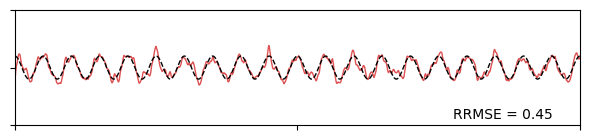

In [25]:
xlims = [0, 1000]
ylims = [-5,5]
xticks = [0, 1000, 2000]
yticks = [-5, 0, 5]
figsize = (6,1.5)
figsize2 = (3,3)

ydat_list = [ds_train[0, :], ds_test[0, :], (WR@rs_test)[0, :], (WR@rs_filt_o)[0, :], (WR@rs_filt_o_opt)[0, :]]
name_list = ["input-train.pdf", "input-test.pdf", "output.pdf", "filtered.pdf", "filtered-opt.pdf"]
color_list = [ "tab:blue", "tab:blue", "tab:orange", "tab:orange", "tab:red" ]

for iydat, ydat in enumerate(ydat_list):
    pl.figure(figsize=figsize)
    pl.plot(range(0,niter_all), ydat, color_list[iydat], alpha=0.8, lw=1)
    pl.plot(ds[0, :], "--k", lw=1)
    pl.xlim(xlims)
    pl.xticks(xticks, [])
    pl.yticks(yticks, [])
    pl.ylim(ylims)
    RMSE = np.sqrt( Fnorm( (ydat - ds)[:, -1000:] ) / 1000 )
    RRMSE = RMSE / ds.std()
    RMSE = np.round(RMSE*100)/100
    RRMSE = np.round(RRMSE*100)/100
    pl.text(1550, -4.5, "RRMSE = "+str( RRMSE ) )
    pl.tight_layout()
    pl.savefig(figdir+name_list[iydat])

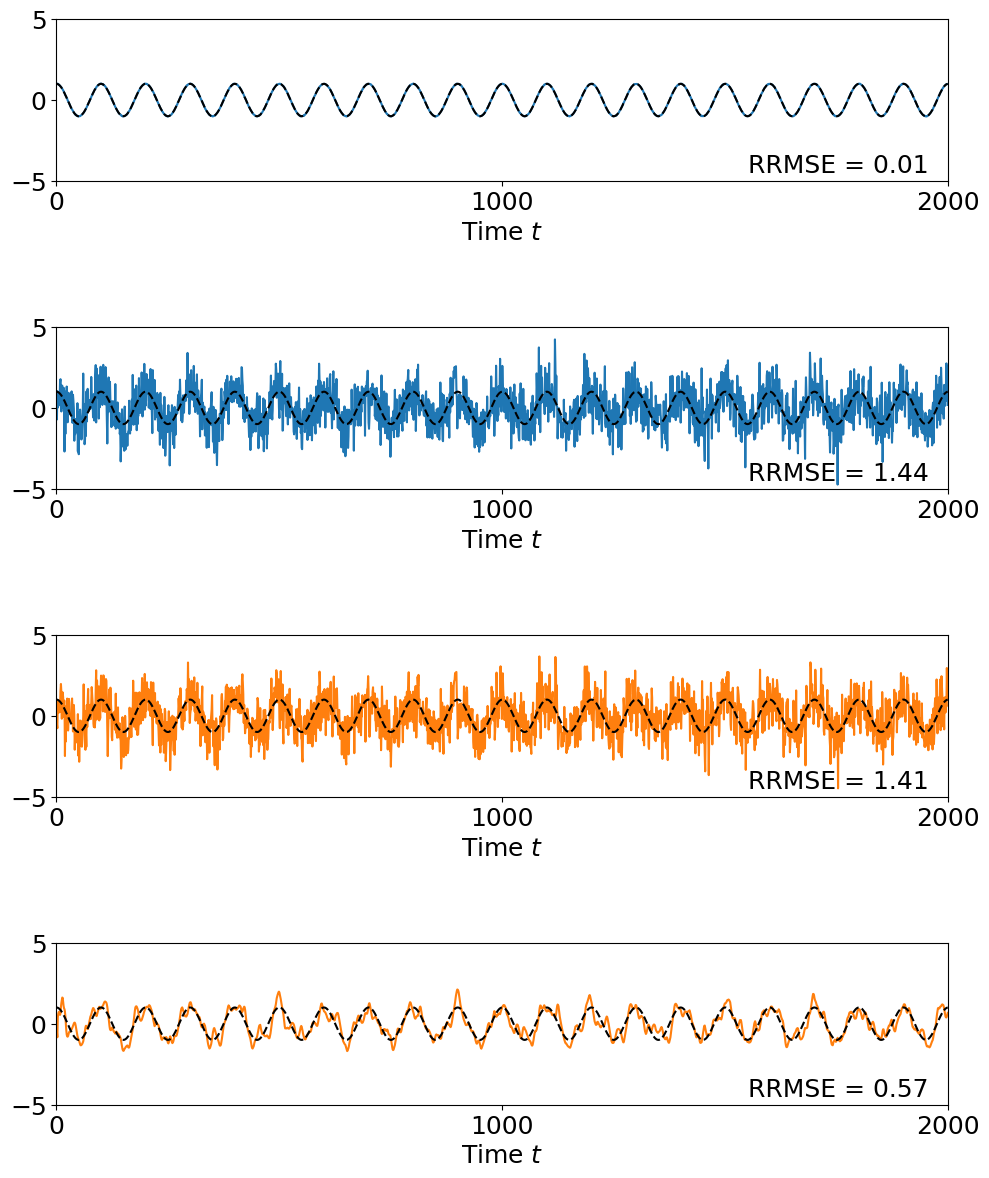

In [36]:
def general_setting(ax, ydat):
    fontsize = 18
    
    ax.plot(ds[0, :], "k--")

    RMSE = np.sqrt( Fnorm( (ydat - ds)[:, -1000:] ) / 1000 )
    RRMSE = RMSE / ds.std()
    RMSE = np.round(RMSE*100)/100
    RRMSE = np.round(RRMSE*100)/100
    pl.text(1550, -4.5, "RRMSE = "+str( RRMSE ), fontsize=fontsize)
    
    
    ax.set_xlim([0, 1200])
    ax.set_ylim([-5,5])
    ax.set_xlabel(r"Time $t$", fontdict={'fontsize': fontsize})
    ax.set_xticks([0, 1000, 2000])
    ax.set_yticks([-5, 0, 5])
    pl.setp(ax.get_xticklabels(), fontsize=fontsize)
    pl.setp(ax.get_yticklabels(), fontsize=fontsize)
    

figsize = (10,12)
fig = pl.figure(figsize=figsize)

ax = fig.add_subplot(4,1,1)
ax.plot(ds_train[0, :])

ax.set_yticks([-3, 0, 3])
general_setting(ax, ds_train[0, :])


ax = fig.add_subplot(4,1,2)
ax.plot(ds_test[0, :])
general_setting(ax, ds_test[0, :])

ax = fig.add_subplot(4,1,3)
ax.plot((WR@rs_test)[0, :], color="tab:orange")
general_setting(ax, (WR@rs_test)[0, :])

ax = fig.add_subplot(4,1,4)
ax.plot((WR@rs_filt_o)[0, :], color="tab:orange")
general_setting(ax, (WR@rs_filt_o)[0, :])

pl.tight_layout()
pl.subplots_adjust(top=0.97, hspace=0.9)
pl.savefig(figdir+"all.pdf")

## Evaluate avarage performance

In [7]:
def noise_filtering(sig_train, sig_test, alpha_R):
    # define input
    niter_all = 2000
    nin = 1
    iters = np.array(range(niter_all))
    ds = np.cos( (2*np.pi/100)*iters ).reshape((nin, -1))
    ds_train = ds + np.random.normal(0,1, ds.shape)*sig_train
    ds_test = ds + np.random.normal(0,1, ds.shape)*sig_test

    #define ESN
    nr = 10
    Aamp = 0.02
    Brho = 0.9
    sig = lambda r: r
    arcsig = lambda r: r
    A, B, g = gen_ESN(nin, nr, Aamp, Brho, sig)

    # simulate ESN (pre training)
    rs_train = np.zeros((nr, niter_all))
    for it in range(niter_all-1):
        rs_train[:, it+1] = g( ds_train[:, it], rs_train[:, it] )
    # Bh = calc_Bhat(rs_train, arcsig)
    Bh = calc_Bhat_reg(rs_train, arcsig, nr, 1e-5)
    WR = calc_WR(rs_train, A, B, arcsig)
    fh_WR = lambda r : sig( Bh@r )
    ws = rs_train[:,1:] - sig( Bh@rs_train[:,:-1] )
    Q = ws@ws.T / (niter_all-2)

    # simulate ESN (noise filtering)
    rs_test = np.zeros((nr, niter_all))
    for it in range(niter_all-1):
        rs_test[:, it+1] = g( ds_test[:, it], rs_test[:, it] )
    vs_opt = rs_test - rs_train
    R_opt = vs_opt@vs_opt.T / (niter_all-2)
    
    # Adaptive Kalman filter
    F = Bh
    G = np.eye(nr)
    H = np.eye(nr)
    rs_filt_p_zero, rs_filt_o_zero, Ps_p_zero, Ps_o_zero, Rs_zero, Ks_zero = EKF_adapt_R(rs_test,F,G,H,Q,0)
    rs_filt_p, rs_filt_o, Ps_p, Ps_o, Rs, Ks = EKF_adapt_R(rs_test,F,G,H,Q,alpha_R)
    rs_filt_p_opt, rs_filt_o_opt, Ps_p_opt, Ps_o_opt, Ks = EKF(rs_test,F,G,H,Q,R_opt)
    return ds, ds_train, ds_test, WR@rs_test, WR@rs_filt_o_zero, WR@rs_filt_o, WR@rs_filt_o_opt

In [8]:
sig_train = 0.01
sig_tests = np.logspace(-2, 1, 10)
alpha_R = 0.1
nsmp = 50
RMSEs = np.zeros((7, len(sig_tests), nsmp))
for isig_test in range(len(sig_tests)):
    for ismp in range(nsmp):
        result = noise_filtering(sig_train, sig_tests[isig_test], alpha_R)
        for i in range(len(result)):
            RMSEs[i,isig_test,ismp] = np.sqrt( Fnorm( (result[i] - result[0])[:, -1000:] ) / 1000 )

RRMSEs = RMSEs / ds.std()

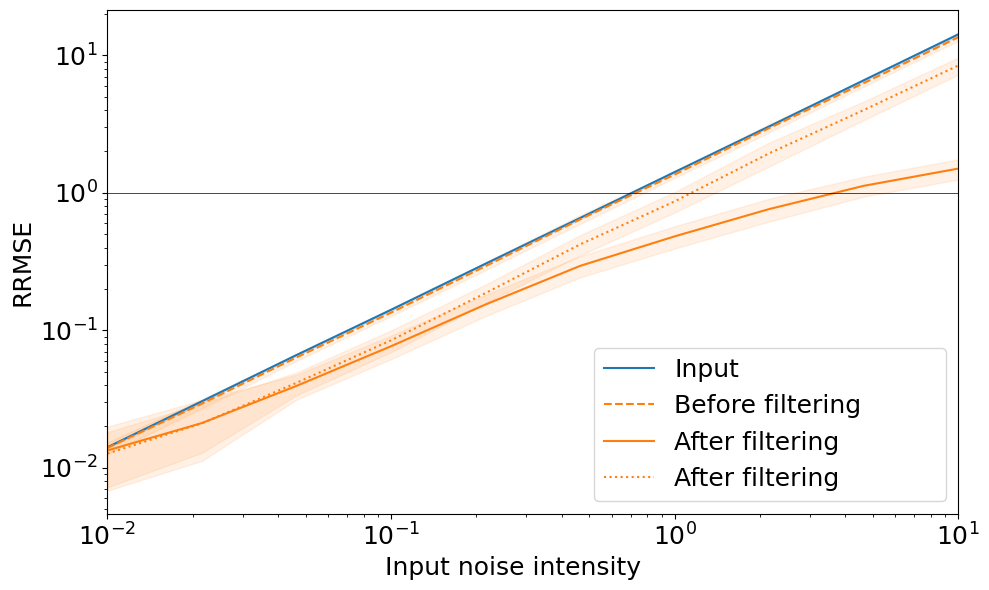

In [46]:
pl.figure(figsize=(10,6))
fontsize = 18
keys = [ "true", "Input_train", "Input", "Before filtering", "After filtering            ", "After filtering",  "After optimal filtering" ]
colors = ["tab:blue", "tab:blue", "tab:blue", "tab:orange", "tab:orange", "tab:orange", "black", "black"]
styles = ["-", "-", "-", "--", ":", "-", "-.", "-."]
for i in [2,3,5,4]:
    m = RRMSEs[i,:,:].mean(axis=-1)
    s = RRMSEs[i,:,:].std(axis=-1)
    pl.plot(sig_tests, m, color=colors[i], linestyle=styles[i], label=keys[i])
    pl.fill_between(sig_tests, m-s, m+s, color=colors[i], alpha=0.1)
pl.hlines( 1, 1e-3, 1e2, "k", linestyle="-", alpha=1, lw=0.5) 
pl.xscale("log")
pl.yscale("log")
pl.xticks([1e-2, 1e-1, 1e0, 1e1], fontsize=fontsize)
pl.yticks([1e-2, 1e-1, 1e0, 1e1], fontsize=fontsize)
pl.xlim([1e-2, 1e1])
pl.legend(loc="lower right", fontsize=fontsize)
pl.ylabel("RRMSE", fontsize=fontsize)
pl.xlabel(r"Input noise intensity     ", fontsize=fontsize)
pl.tight_layout()
pl.savefig(figdir+"RRMSE-mean.pdf")